In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import numpy as np
import os
pd.options.display.float_format = '{:.2f}'.format
import math
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.stats.sandwich_covariance as sw

from plotnine import *
import statsmodels.formula.api as smf
from arch.unitroot import PhillipsPerron
from stargazer.stargazer import Stargazer


In [2]:
# Carregar o arquivo Excel
df = pd.read_excel("DataFrame_Valores.xlsx")

df

,Ano,Freguesia,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro
0,2007,Ajuda,1941.00,0.00,8957.00,0.00,65807.06,1271.04,4.82
1,2008,Ajuda,1785.25,0.00,8937.50,0.00,67581.69,1285.38,3.37
2,2009,Ajuda,2099.30,0.00,8918.00,0.00,66436.60,1651.43,1.00
3,2010,Ajuda,2030.13,0.00,8898.50,0.00,67732.97,1880.53,1.25
4,2011,Ajuda,1681.89,0.00,8879.00,0.00,66343.85,2013.33,1.67
...,...,...,...,...,...,...,...,...,...
403,2019,São Vicente,3735.44,1662.00,10202.60,0.00,77439.68,6128.30,-0.34
404,2020,São Vicente,3797.13,1631.00,10189.30,0.00,71642.26,6329.82,-0.52
405,2021,São Vicente,3926.75,1614.00,10176.00,0.00,76602.81,7171.80,-0.55
406,2022,São Vicente,4241.94,1607.00,10162.70,133.34,87368.25,7782.02,2.57


In [3]:
# Colocar a coluna 'Anos' como a primeira coluna
df['Anos'] = df['Ano']-2007
df.insert(0, 'Anos', df.pop('Anos'))

df

,Anos,Ano,Freguesia,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro
0,0,2007,Ajuda,1941.00,0.00,8957.00,0.00,65807.06,1271.04,4.82
1,1,2008,Ajuda,1785.25,0.00,8937.50,0.00,67581.69,1285.38,3.37
2,2,2009,Ajuda,2099.30,0.00,8918.00,0.00,66436.60,1651.43,1.00
3,3,2010,Ajuda,2030.13,0.00,8898.50,0.00,67732.97,1880.53,1.25
4,4,2011,Ajuda,1681.89,0.00,8879.00,0.00,66343.85,2013.33,1.67
...,...,...,...,...,...,...,...,...,...,...
403,12,2019,São Vicente,3735.44,1662.00,10202.60,0.00,77439.68,6128.30,-0.34
404,13,2020,São Vicente,3797.13,1631.00,10189.30,0.00,71642.26,6329.82,-0.52
405,14,2021,São Vicente,3926.75,1614.00,10176.00,0.00,76602.81,7171.80,-0.55
406,15,2022,São Vicente,4241.94,1607.00,10162.70,133.34,87368.25,7782.02,2.57


In [4]:
# Convert all columns to integers except "Freguesia" e "Taxa de Juro" column
cols_to_convert = df.columns.difference(['perc_Juro','Freguesia'])
df[cols_to_convert] = df[cols_to_convert].apply(lambda x: x.astype('int'))
df

,Anos,Ano,Freguesia,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro
0,0,2007,Ajuda,1941,0,8957,0,65807,1271,4.82
1,1,2008,Ajuda,1785,0,8937,0,67581,1285,3.37
2,2,2009,Ajuda,2099,0,8918,0,66436,1651,1.00
3,3,2010,Ajuda,2030,0,8898,0,67732,1880,1.25
4,4,2011,Ajuda,1681,0,8879,0,66343,2013,1.67
...,...,...,...,...,...,...,...,...,...,...
403,12,2019,São Vicente,3735,1662,10202,0,77439,6128,-0.34
404,13,2020,São Vicente,3797,1631,10189,0,71642,6329,-0.52
405,14,2021,São Vicente,3926,1614,10176,0,76602,7171,-0.55
406,15,2022,São Vicente,4241,1607,10162,133,87368,7782,2.57


## Novas Variáveis

In [5]:
df['perc_AL_H'] = (df['N_AL']/df['N_H'])*100

df.loc[df['Ano'] > 2011, 'perc_AL_H'] = (df['N_AL']/(df['N_H']++df['N_AL']))*100

df['log_Preço_m2'] = np.log(df['Preço_m2'])

df

,Anos,Ano,Freguesia,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro,perc_AL_H,log_Preço_m2
0,0,2007,Ajuda,1941,0,8957,0,65807,1271,4.82,0.00,7.57
1,1,2008,Ajuda,1785,0,8937,0,67581,1285,3.37,0.00,7.49
2,2,2009,Ajuda,2099,0,8918,0,66436,1651,1.00,0.00,7.65
3,3,2010,Ajuda,2030,0,8898,0,67732,1880,1.25,0.00,7.62
4,4,2011,Ajuda,1681,0,8879,0,66343,2013,1.67,0.00,7.43
...,...,...,...,...,...,...,...,...,...,...,...,...
403,12,2019,São Vicente,3735,1662,10202,0,77439,6128,-0.34,14.01,8.23
404,13,2020,São Vicente,3797,1631,10189,0,71642,6329,-0.52,13.80,8.24
405,14,2021,São Vicente,3926,1614,10176,0,76602,7171,-0.55,13.69,8.28
406,15,2022,São Vicente,4241,1607,10162,133,87368,7782,2.57,13.65,8.35


## Gráficos das variáveis

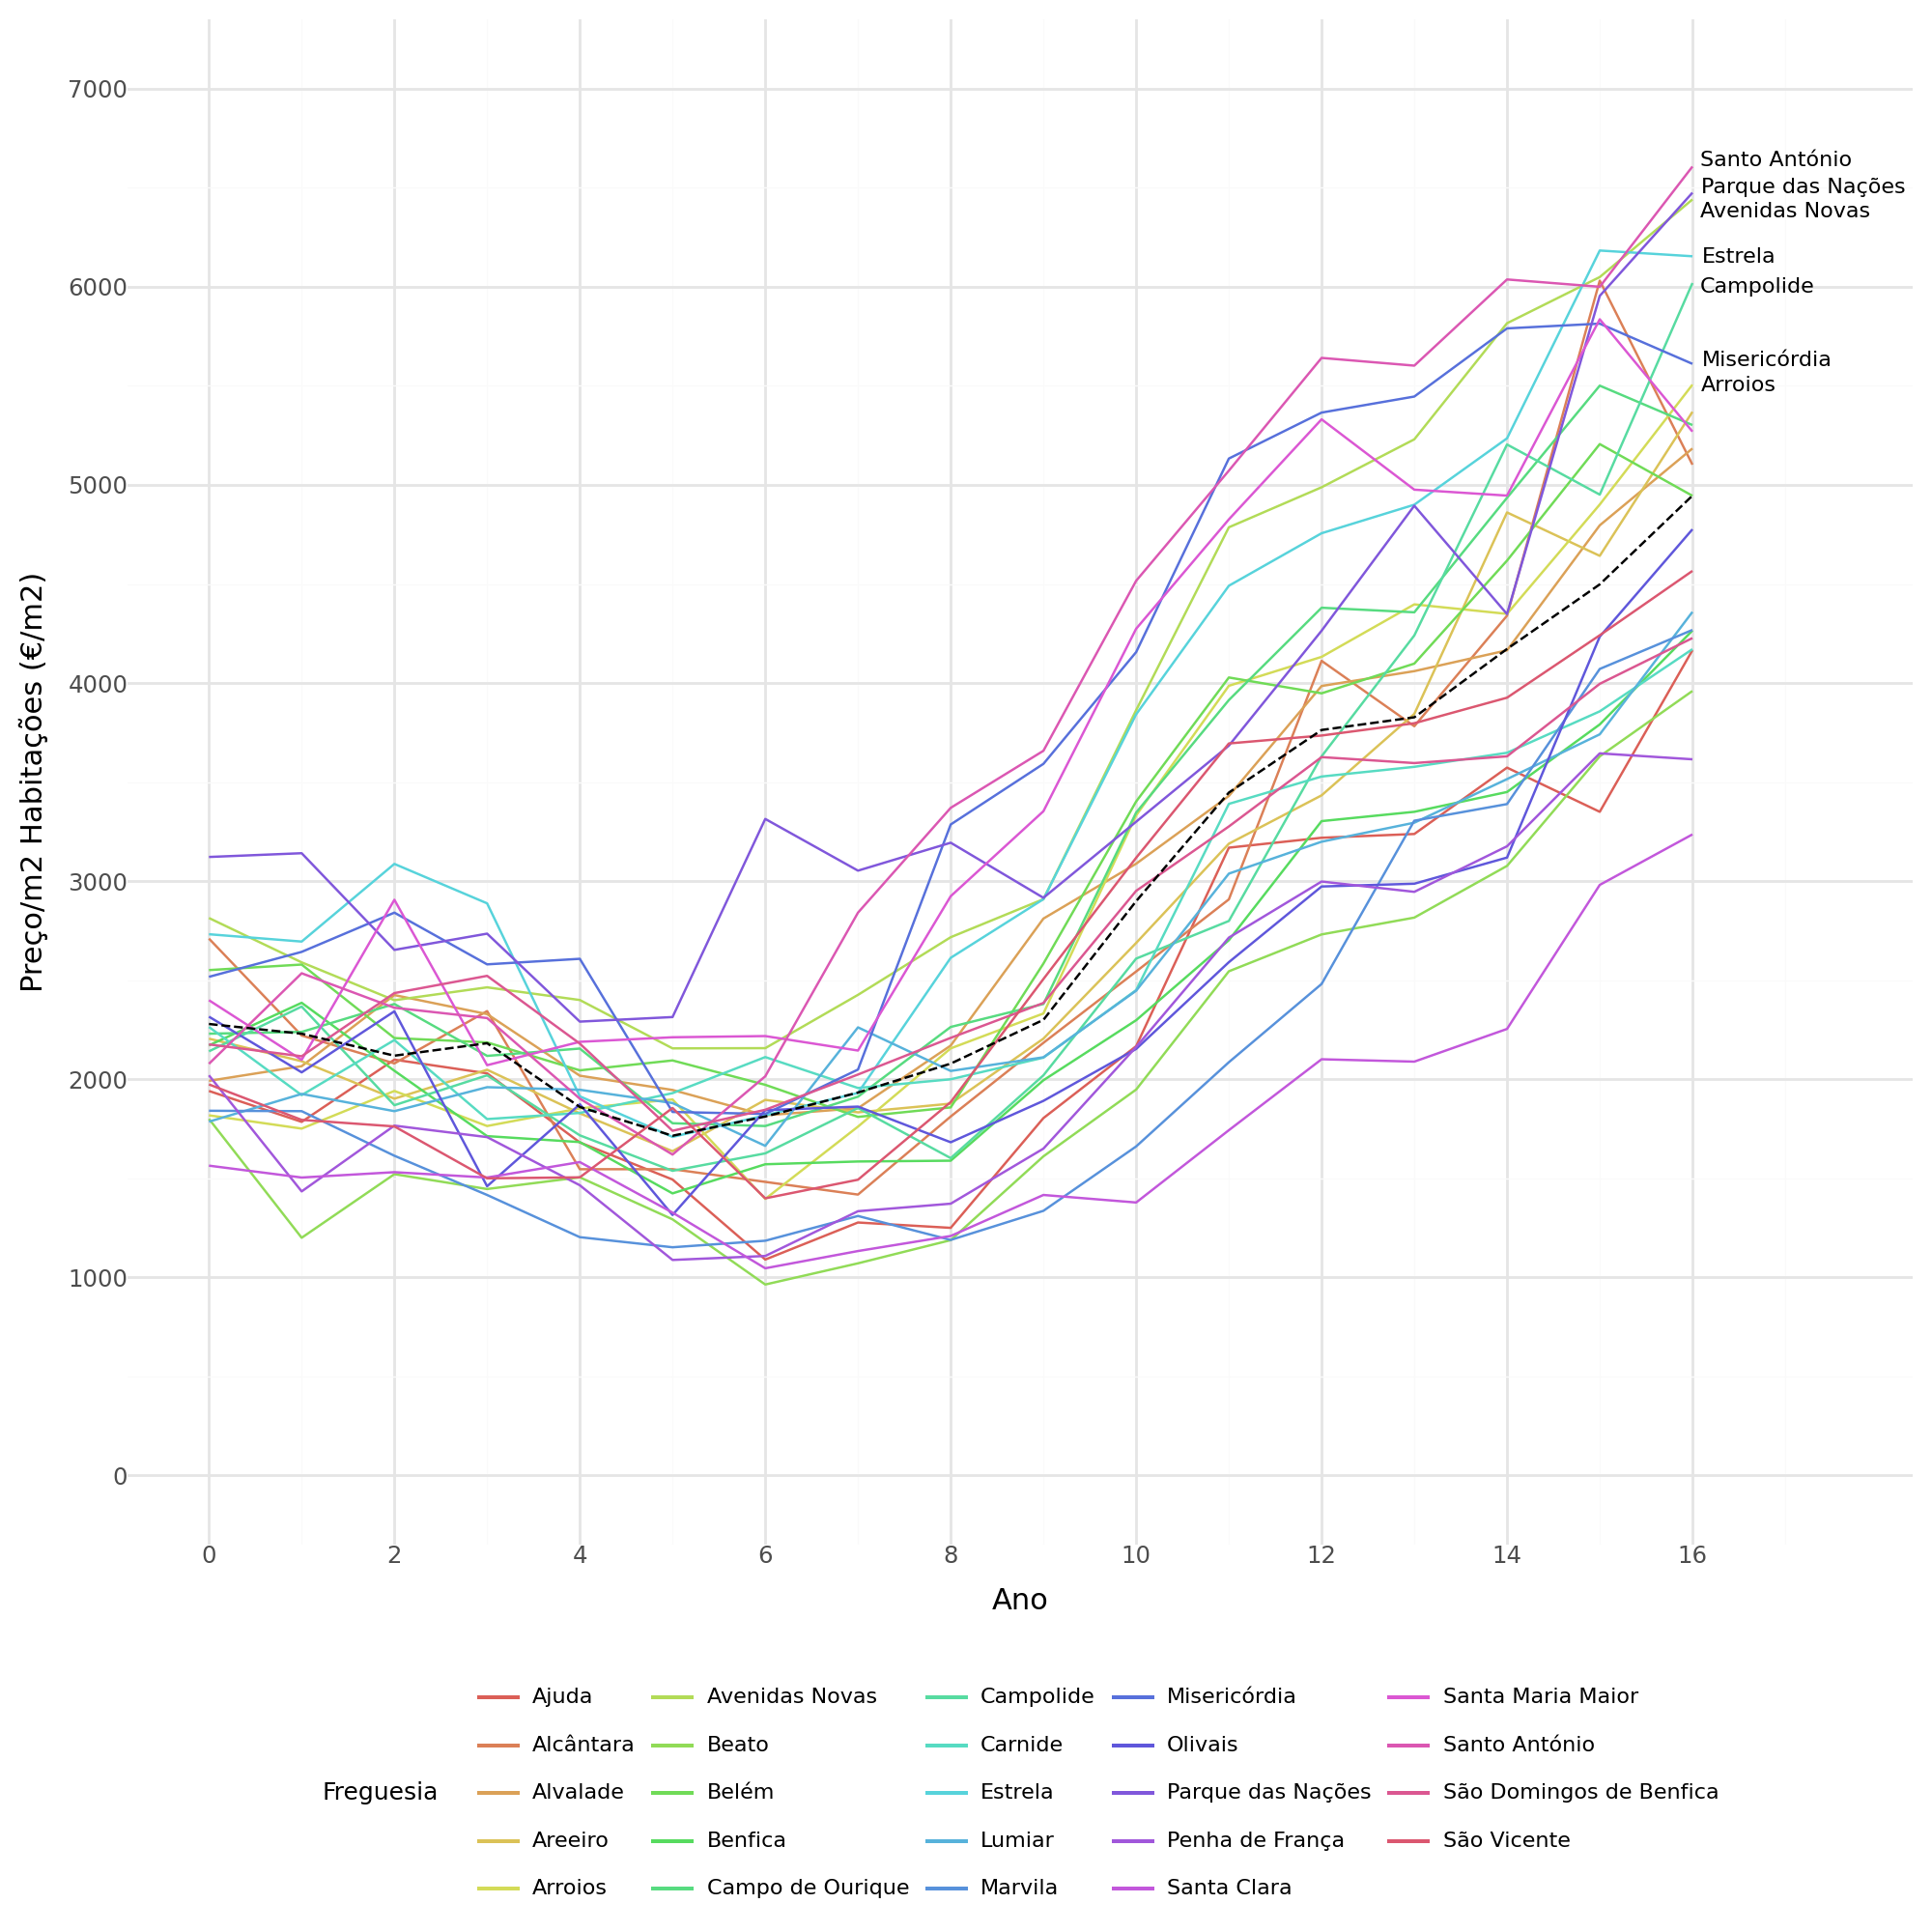

In [6]:
data = {"Anos": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        "Preço_m2": [2279, 2230, 2119, 2182, 1860, 1715, 1812, 1933, 2079, 2300, 2899, 3447, 3763, 3827, 4172, 4498, 4946]}
df_preco_m2_lx = pd.DataFrame(data)
df_preco_m2_lx['Freguesia']="Lisboa"

g1 = (
    ggplot(df, aes(x="Anos", y="Preço_m2", color='Freguesia', group='Freguesia'))
    + geom_line(aes(x='Anos', y='Preço_m2',group='Freguesia'))
    + geom_line(df_preco_m2_lx, color='black', linetype='dashed')
    + labs(x="Ano", y="Preço/m2 Habitações (€/m2)")
    + scale_y_continuous(limits=[0, 7000], breaks=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000])
    + scale_x_continuous(limits=[0, 17.5], breaks=[0,2,4,6,8,10,12,14,16])
    + theme_minimal()
    + theme(legend_position='bottom',  # Move legend to the bottom
            legend_title=element_text(size=9),  # Adjust legend title size
            legend_text=element_text(size=8),  # Adjust legend text size
            figure_size=(10, 10)) # Adjust figure size to fit legend
    + annotate('text', x=16.9, y=6640, label='Santo António', size=8)
    + annotate('text', x=17.2, y=6500, label='Parque das Nações', size=8)
    + annotate('text', x=17, y=6380, label='Avenidas Novas', size=8)
    + annotate('text', x=16.5, y=6150, label='Estrela', size=8)
    + annotate('text', x=16.7, y=6000, label='Campolide', size=8)
    + annotate('text', x=16.8, y=5630, label='Misericórdia', size=8)
    + annotate('text', x=16.5, y=5500, label='Arroios', size=8)     
)
g1

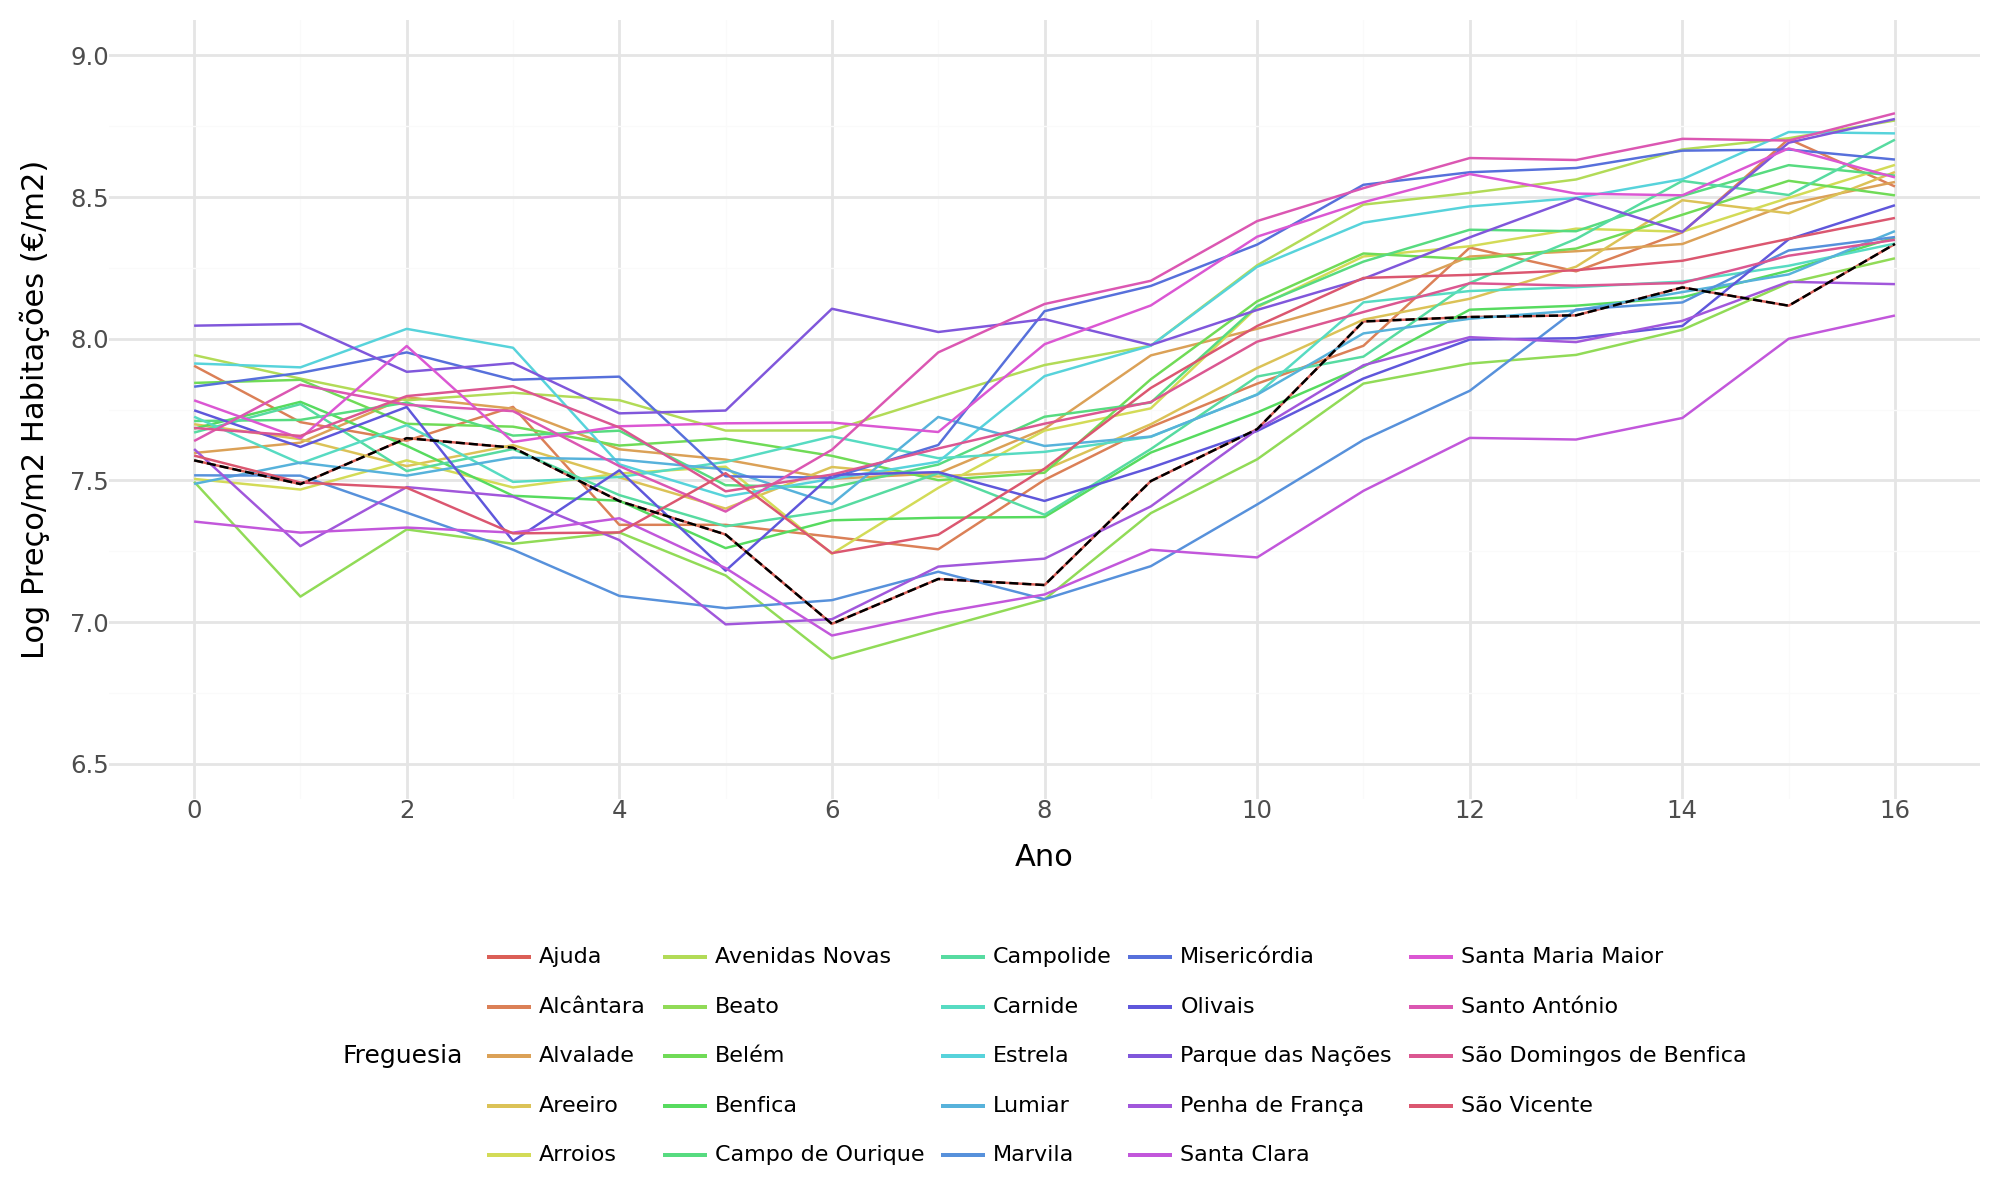

In [7]:
df_preco_m2_lx['log_Preço_m2']=np.log(df['Preço_m2'])

g1 = (
    ggplot(df, aes(x="Anos", y="log_Preço_m2", color='Freguesia', group='Freguesia'))
    + geom_line()
    + geom_line(df_preco_m2_lx, aes(x='Anos', y='log_Preço_m2',group='Freguesia'), color='black', linetype='dashed')
    + labs(x="Ano", y="Log Preço/m2 Habitações (€/m2)")
    + scale_y_continuous(limits=[6.5, 9], breaks=[6.5, 7, 7.5, 8, 8.5, 9])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_minimal()
    + theme(legend_position='bottom',  # Move legend to the bottom
            legend_title=element_text(size=9),  # Adjust legend title size
            legend_text=element_text(size=8),  # Adjust legend text size
            figure_size=(10, 6)) # Adjust figure size to fit legend
)
g1

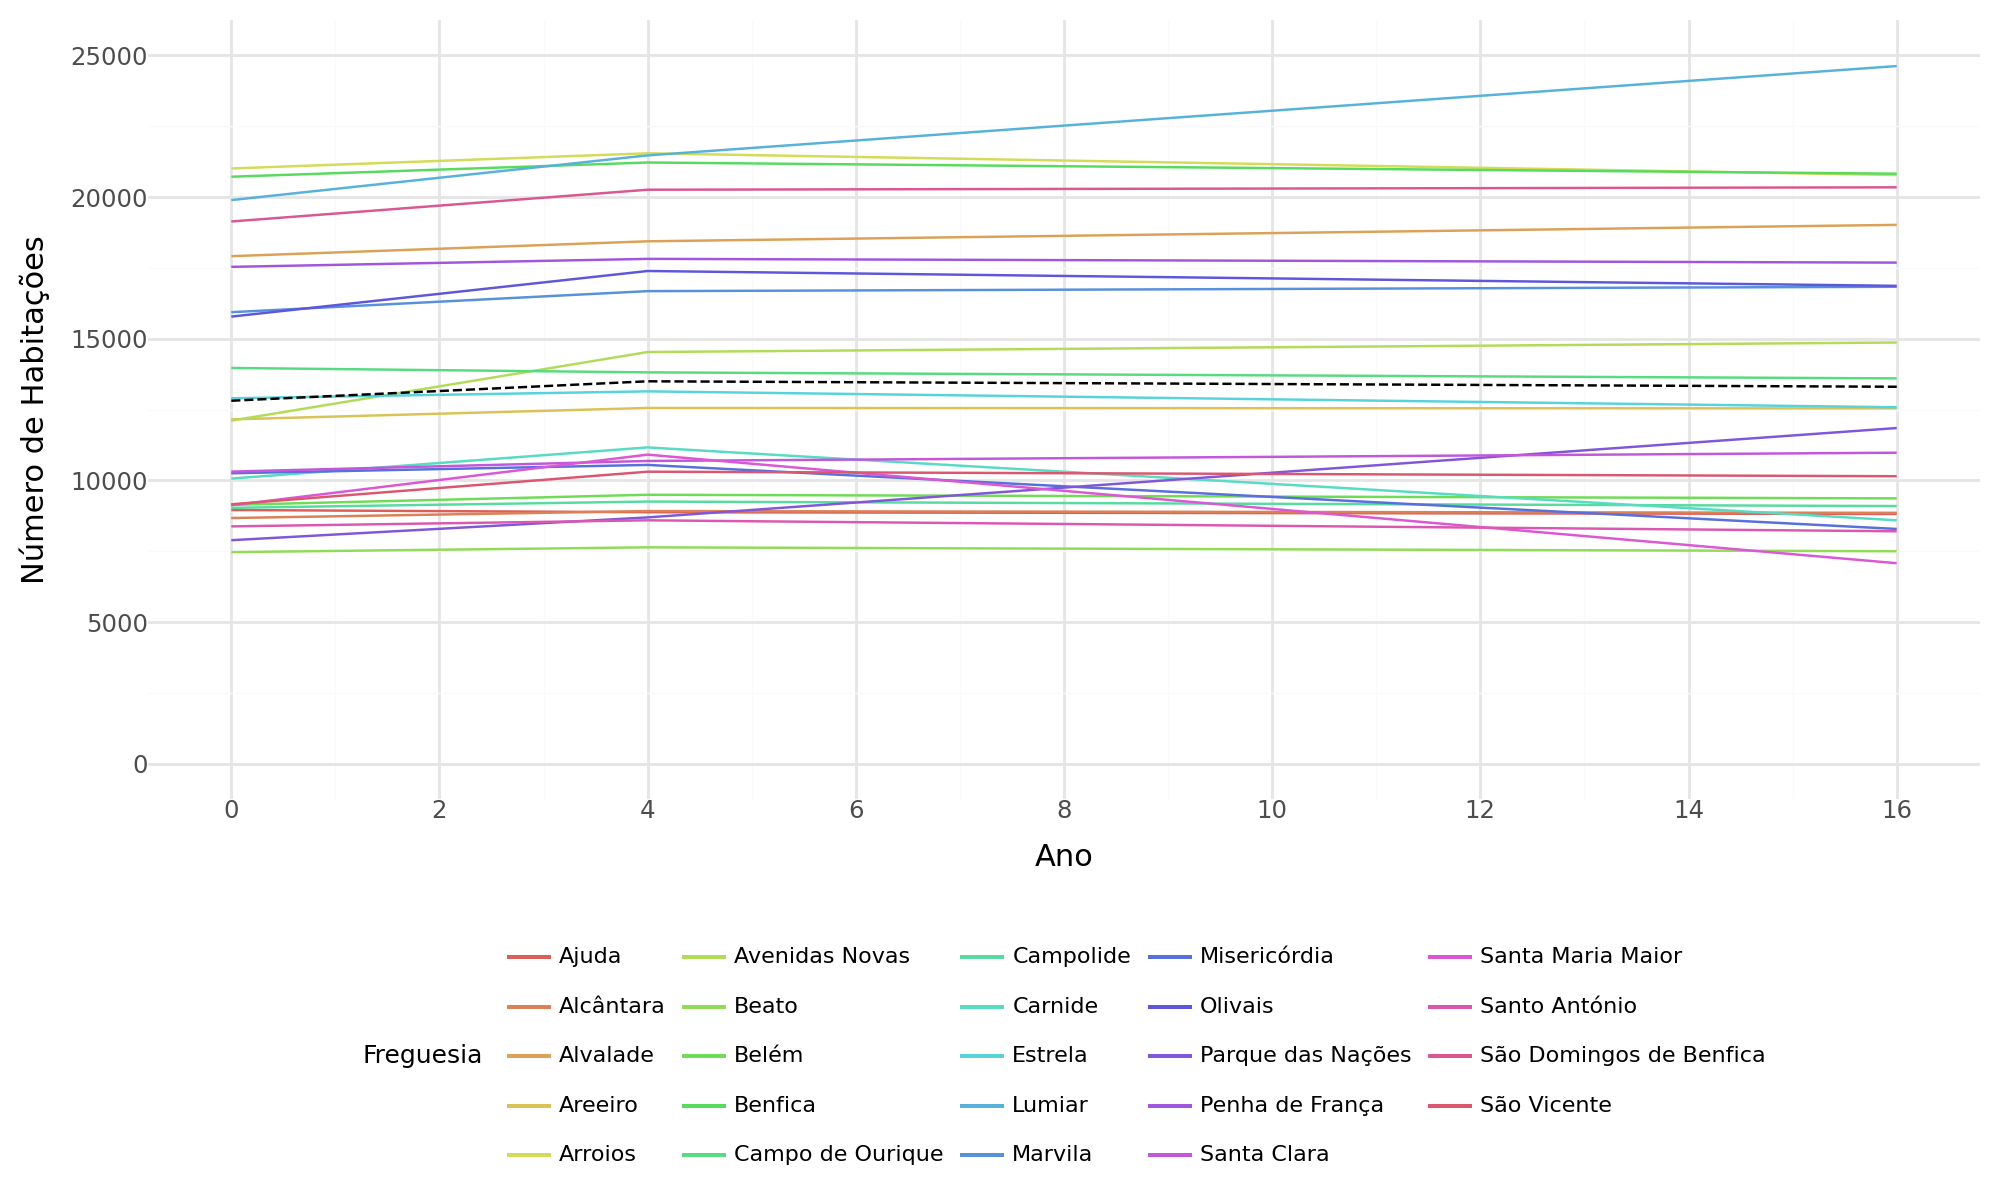

In [8]:
#Não sei se a média faz sentido. Mas mostrar a soma, fazia com que o gráfico tivesse escalas muito diferentes
df_avg = df.groupby('Anos', as_index=False)['N_H'].mean()
df_avg['Freguesia'] = 'Média Lisboa'

g1 = (
    ggplot(df, aes(x="Anos", y="N_H", color='Freguesia', group='Freguesia'))
    + geom_line()
    + geom_line(df_avg, aes(x='Anos', y='N_H',group='Freguesia'), color='black', linetype='dashed')
    + labs(x="Ano", y="Número de Habitações")
    + scale_y_continuous(limits=[0, 25000], breaks=[0, 5000, 10000, 15000, 20000, 25000])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_minimal()
    + theme(legend_position='bottom',  # Move legend to the bottom
            legend_title=element_text(size=9),  # Adjust legend title size
            legend_text=element_text(size=8),  # Adjust legend text size
            figure_size=(10, 6)) # Adjust figure size to fit legend
)
g1

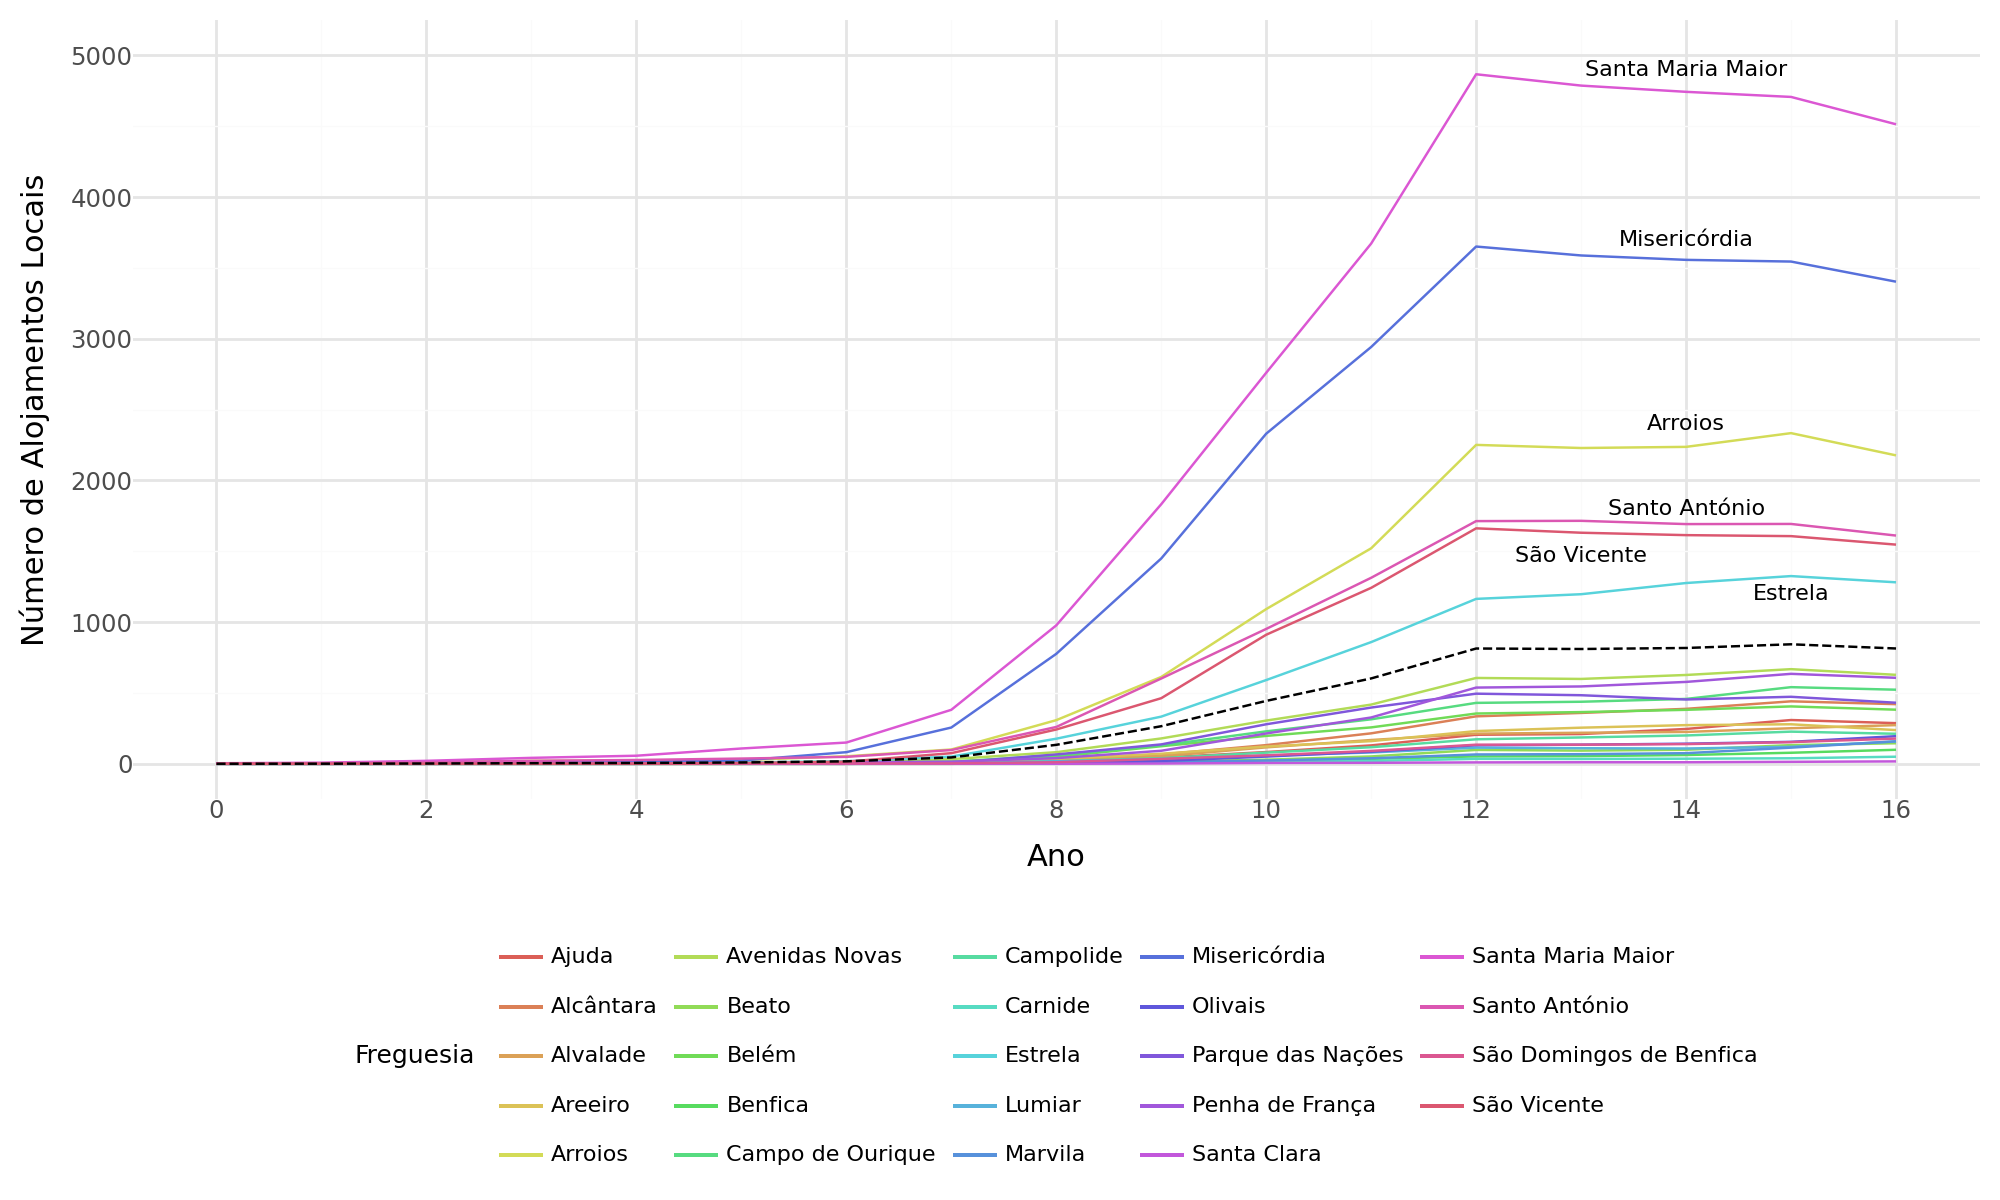

In [9]:
#Não sei se a média faz sentido. Mas mostrar a soma, fazia com que o gráfico tivesse escalas muito diferentes
df_avg = df.groupby('Anos', as_index=False)['N_AL'].mean()
df_avg['Freguesia'] = 'Média Lisboa'

g1 = (
    ggplot(df, aes(x="Anos", y="N_AL", color='Freguesia', group='Freguesia'))
    + geom_line()
    + geom_line(df_avg, aes(x='Anos', y='N_AL',group='Freguesia'), color='black', linetype='dashed')
    + labs(x="Ano", y="Número de Alojamentos Locais")
    + scale_y_continuous(limits=[0, 5000], breaks=[0, 1000, 2000, 3000, 4000, 5000])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_minimal()
    + theme(legend_position='bottom',  # Move legend to the bottom
            legend_title=element_text(size=9),  # Adjust legend title size
            legend_text=element_text(size=8),  # Adjust legend text size
            figure_size=(10, 6)) # Adjust figure size to fit legend
    + annotate('text', x=14, y=4900, label='Santa Maria Maior', size=8)
    + annotate('text', x=14, y=3700, label='Misericórdia', size=8)
    + annotate('text', x=14, y=2400, label='Arroios', size=8)
    + annotate('text', x=14, y=1800, label='Santo António', size=8)
    + annotate('text', x=13, y=1470, label='São Vicente', size=8)
    + annotate('text', x=15, y=1200, label='Estrela', size=8)  
)
g1

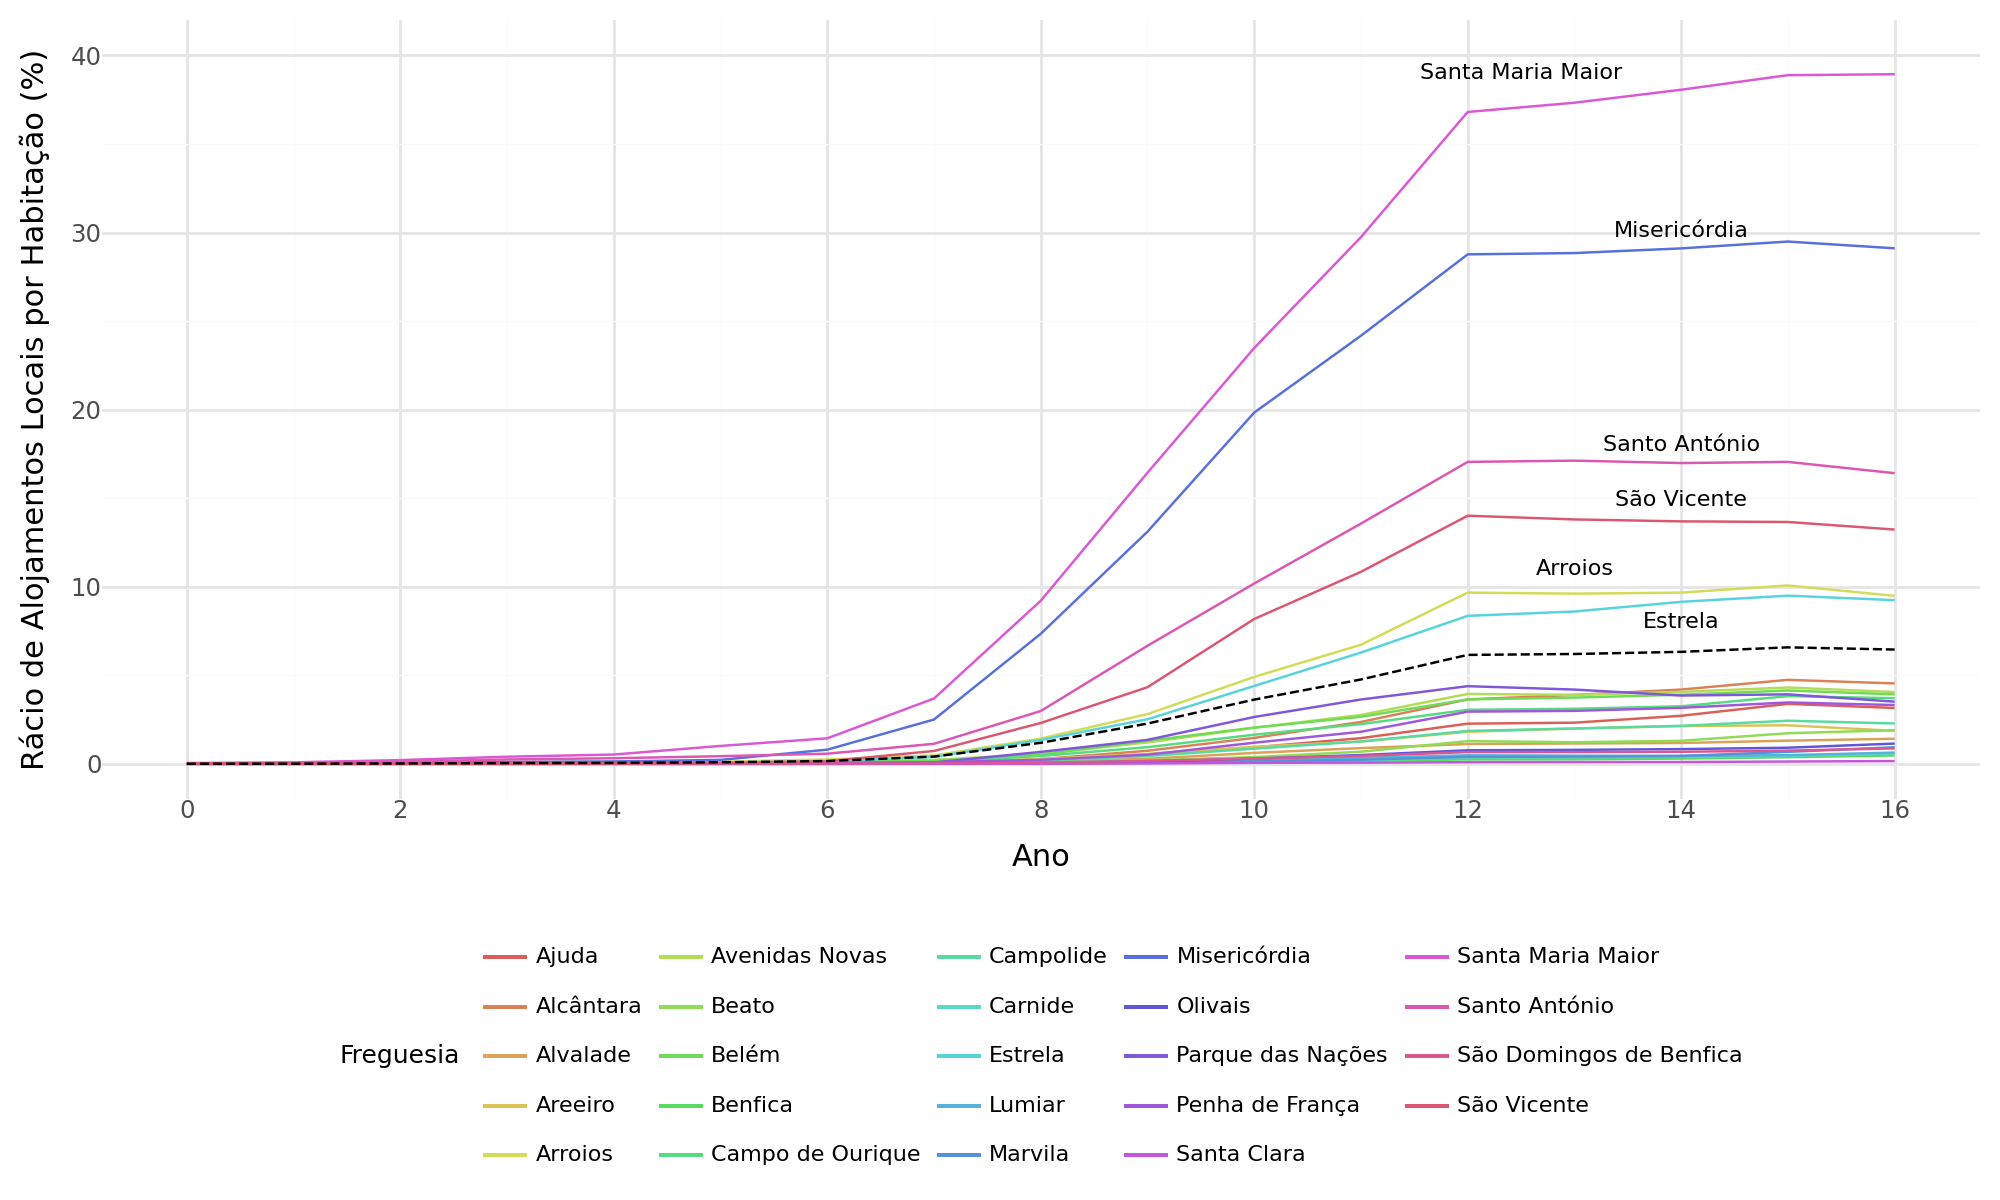

In [10]:
#Não sei se a média faz sentido. Mas mostrar a soma, fazia com que o gráfico tivesse escalas muito diferentes
df_avg = df.groupby('Anos', as_index=False)['perc_AL_H'].mean()
df_avg['Freguesia'] = 'Média Lisboa'

g1 = (
    ggplot(df, aes(x="Anos", y="perc_AL_H", color='Freguesia', group='Freguesia'))
    + geom_line()
    + geom_line(df_avg, aes(x='Anos', y='perc_AL_H',group='Freguesia'), color='black', linetype='dashed')
    + labs(x="Ano", y="Rácio de Alojamentos Locais por Habitação (%)")
    + scale_y_continuous(limits=[0, 40], breaks=[0, 10, 20, 30, 40, 50, 60, 70])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_minimal()
    + theme(legend_position='bottom',  # Move legend to the bottom
            legend_title=element_text(size=9),  # Adjust legend title size
            legend_text=element_text(size=8),  # Adjust legend text size
            figure_size=(10, 6)) # Adjust figure size to fit legend
    + annotate('text', x=12.5, y=39, label='Santa Maria Maior', size=8)
    + annotate('text', x=14, y=30.1, label='Misericórdia', size=8)
    + annotate('text', x=14, y=18, label='Santo António', size=8)
    + annotate('text', x=14, y=14.9, label='São Vicente', size=8)
    + annotate('text', x=13, y=11, label='Arroios', size=8)
    + annotate('text', x=14, y=8, label='Estrela', size=8) 
)
g1

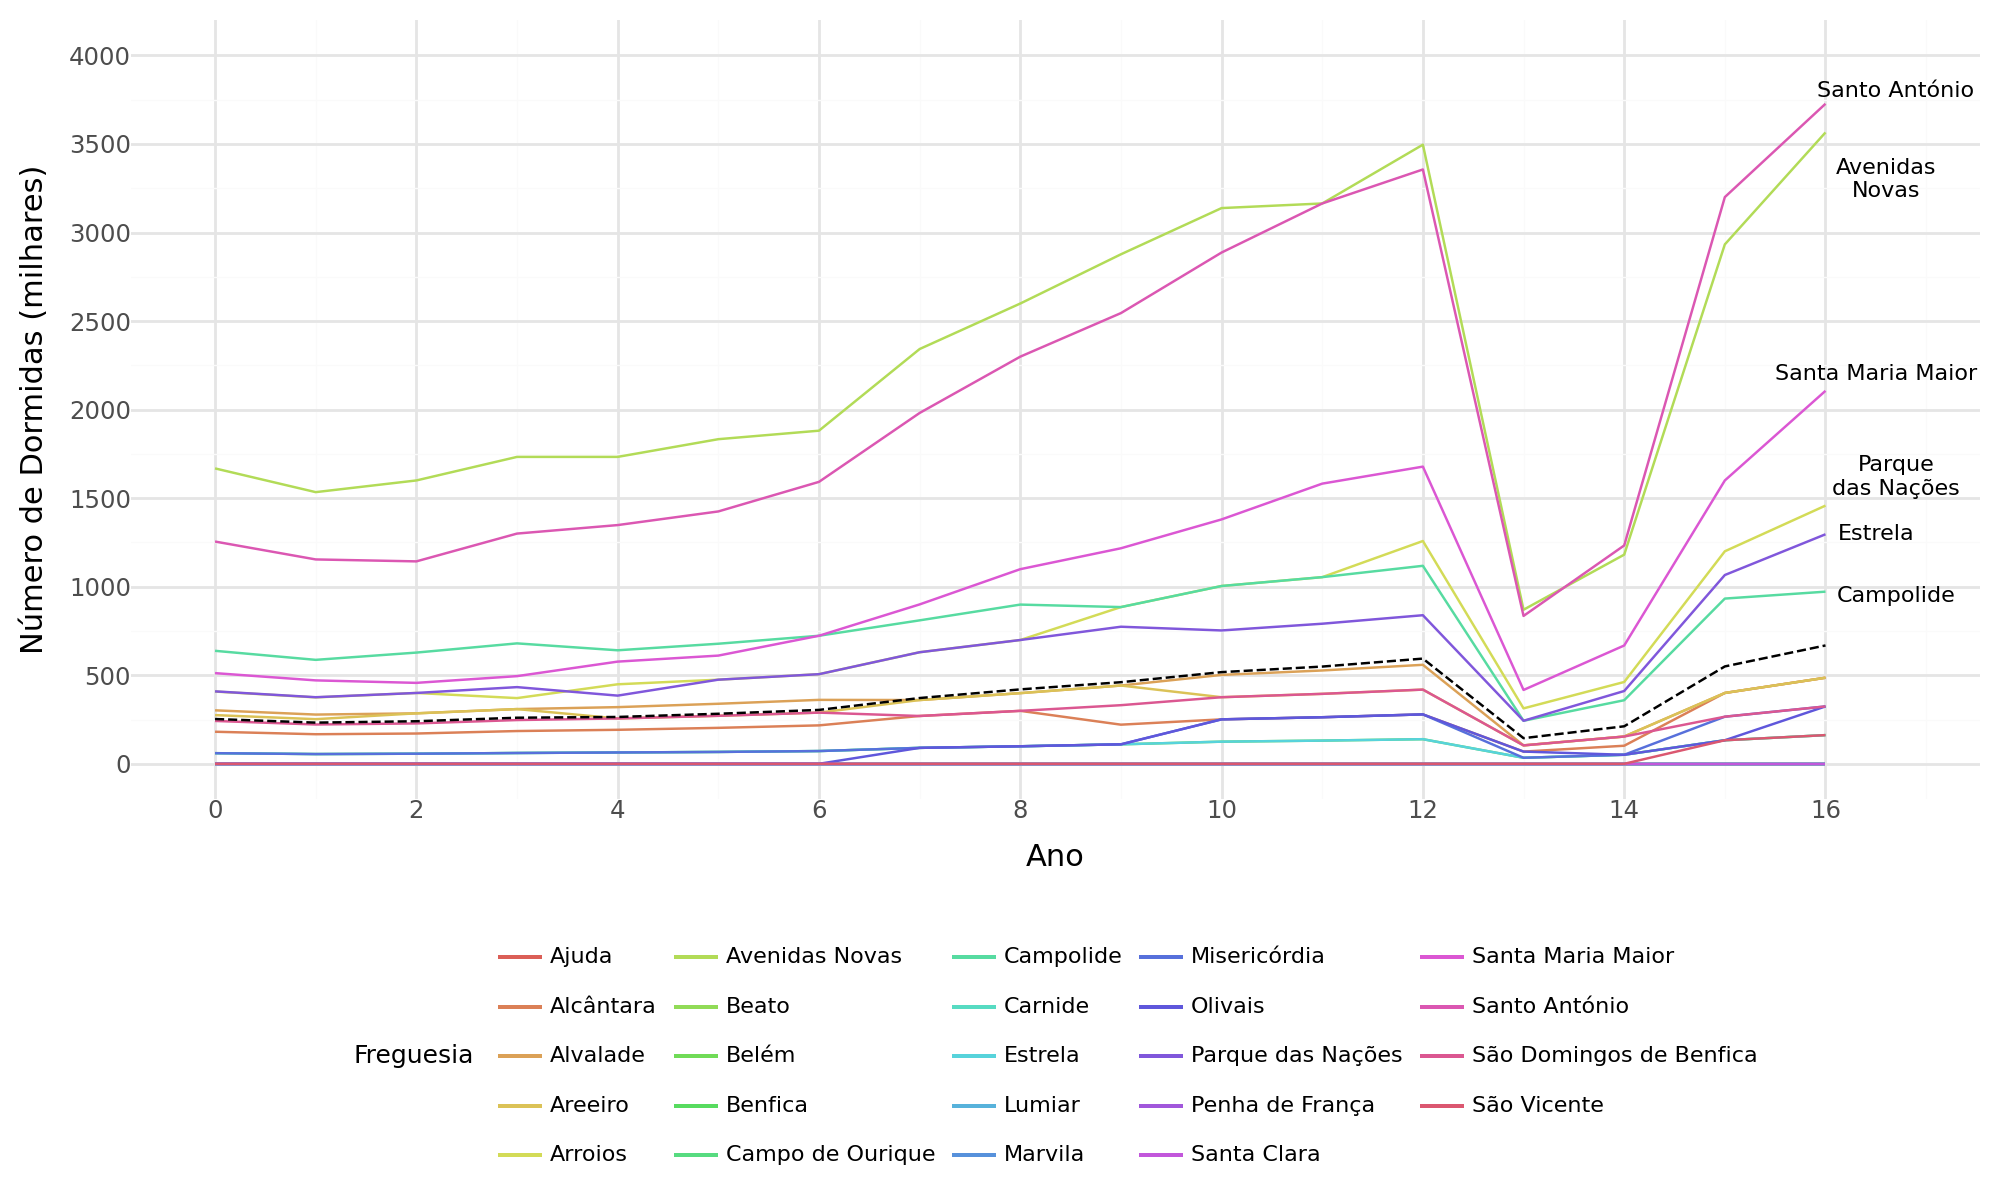

In [11]:
#Não sei se a média faz sentido. Mas mostrar a soma, fazia com que o gráfico tivesse escalas muito diferentes
df_avg = df.groupby('Anos', as_index=False)['N_D'].mean()
df_avg['Freguesia'] = 'Média Lisboa'

g1 = (
    ggplot(df, aes(x="Anos", y="N_D", color='Freguesia', group='Freguesia'))
    + geom_line()
    + geom_line(df_avg, aes(x='Anos', y='N_D',group='Freguesia'), color='black', linetype='dashed')
    + labs(x="Ano", y="Número de Dormidas (milhares)")
    + scale_y_continuous(limits=[0, 4E3], breaks=[0, 0.5E3, 1E3, 1.5E3, 2E3, 2.5E3, 3E3, 3.5E3, 4E3])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_minimal()
    + theme(legend_position='bottom',  # Move legend to the bottom
            legend_title=element_text(size=9),  # Adjust legend title size
            legend_text=element_text(size=8),  # Adjust legend text size
            figure_size=(10, 6)) # Adjust fiSgure size to fit legend
    + annotate('text', x=16.7, y=3800, label='Santo António', size=8)
    + annotate('text', x=16.6, y=3300, label='Avenidas\nNovas', size=8)
    + annotate('text', x=16.5, y=2200, label='Santa Maria Maior', size=8)
    + annotate('text', x=16.7, y=1620, label='Parque\ndas Nações', size=8)
    + annotate('text', x=16.5, y=1300, label='Estrela', size=8)
    + annotate('text', x=16.7, y=950, label='Campolide', size=8)      
)

g1


# Fixed Effects

In [12]:
from linearmodels import PanelOLS

In [13]:
#Cria os campos a e f para serem definidos como índices do painel de dados
df['a'] = df['Ano']
df['f'] = df['Freguesia']

df = df.set_index(["f", "a"])  # Define um índice multi-nível usando f e a (i.e. "Freguesia" e "Ano")

df['Ano'] = df['Ano'].astype('category') # Converte o campo Ano do tipo numérico para categórico

df

Anos   Ano    Freguesia  Preço_m2  N_AL    N_H  N_D  \
f           a                                                           
Ajuda       2007     0  2007        Ajuda      1941     0   8957    0   
            2008     1  2008        Ajuda      1785     0   8937    0   
            2009     2  2009        Ajuda      2099     0   8918    0   
            2010     3  2010        Ajuda      2030     0   8898    0   
            2011     4  2011        Ajuda      1681     0   8879    0   
...                ...   ...          ...       ...   ...    ...  ...   
São Vicente 2019    12  2019  São Vicente      3735  1662  10202    0   
            2020    13  2020  São Vicente      3797  1631  10189    0   
            2021    14  2021  São Vicente      3926  1614  10176    0   
            2022    15  2022  São Vicente      4241  1607  10162  133   
            2023    16  2023  São Vicente      4566  1547  10149  162   

                  PIB_AML  IDE_CI_GL  perc_Juro  perc_AL_H  log_Preço_m2  
f           a                                                             
Ajuda       2007    65807       1271       4.82       0.00          7.57  
            2008    67581       1285       3.37       0.00          7.49  
            2009    66436       1651       1.00       0.00          7.65  
            2010    67732       1880       1.25       0.00          7.62  
            2011    66343       2013       1.67       0.00          7.43  
...                   ...        ...        ...        ...           ...  
São Vicente 2019    77439       6128      -0.34      14.01          8.23  
            2020    71642       6329      -0.52      13.80          8.24  
            2021    76602       7171      -0.55      13.69          8.28  
            2022    87368       7782       2.57      13.65          8.35  
            2023    96325       8073       3.92      13.23          8.43  

[408 rows x 12 columns]

## Calcular as regressões com Y = Preço_m2 e 𝑋 = N_AL

### 𝑌(i,t) = 𝛼(i) + 𝛽 𝑋(i,t)

In [14]:
fe = PanelOLS.from_formula("Preço_m2 ~ N_AL + EntityEffects",df).fit(cov_type="clustered", cluster_entity=True)
#fe.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽 𝑋(i,t)

In [15]:
fe_t = PanelOLS.from_formula("Preço_m2 ~ N_AL + Ano + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽 𝑋(i,t) + δ C(i,t)

In [16]:
fe_t_c = PanelOLS.from_formula("Preço_m2 ~ N_AL + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽0 𝑋(i,t) + 𝛽1 𝑋(i,t-1) + δ C(i,t)

In [17]:
fe_t_c_s1 = PanelOLS.from_formula("Preço_m2 ~ N_AL + N_AL.shift(1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_s1.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽0 𝑋(i,t) + 𝛽1 𝑋(i,t-1) + 𝛽2 𝑋(i,t-2) + δ C(i,t)

In [18]:
fe_t_c_s2 = PanelOLS.from_formula("Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_s2.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽0 𝑋(i,t) + 𝛽1 𝑋(i,t-1) + k1 𝑋(i,t+1) + δ C(i,t)

In [19]:
fe_t_c_sm1 = PanelOLS.from_formula("Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(-1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_sm1.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽0 𝑋(i,t) + 𝛽1 𝑋(i,t-1) + k1 𝑋(i,t+1) + k2 𝑋(i,t+2) + δ C(i,t)

In [20]:
fe_t_c_sm2 = PanelOLS.from_formula("Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(-1) + N_AL.shift(-2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_sm2.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽0 𝑋(i,t) + 𝛽1 𝑋(i,t-1) + k1 𝑋(i,t+1) + k2 𝑋(i,t+2) + k3 𝑋(i,t+3) + δ C(i,t)

In [21]:
fe_t_c_sm3 = PanelOLS.from_formula("Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(-1) + N_AL.shift(-2) + N_AL.shift(-3) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_sm3.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


### Conclusões:

- O efeito causal de cada AL adicional numa freguesia corresponde a um aumento no preço de cerca de 0,4 €/m2 (equações 2 e 3)
- Existe evidência de que o aumento do preço faz aumentar o número de alojamentos locais ( 1 € => 0,17 AL ) (equações 7 e 8)

In [22]:
stargazer = Stargazer([fe, fe_t, fe_t_c, fe_t_c_s1, fe_t_c_s2, fe_t_c_sm1, fe_t_c_sm2, fe_t_c_sm3])
stargazer.covariate_order(["N_AL", "N_AL.shift(1)", "N_AL.shift(2)", "N_AL.shift(-1)", "N_AL.shift(-2)", "N_AL.shift(-3)", "N_H","N_D","Ano[T.2007]","Ano[T.2023]"])
stargazer

## Calcular as regressões com Y = log_Preço_m2 e 𝑋 = N_AL

### 𝑌(i,t) = 𝛼(i) + 𝛽 𝑋(i,t)

In [23]:
fe = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + EntityEffects",df).fit(cov_type="clustered", cluster_entity=True)
#fe.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽 𝑋(i,t)

In [24]:
fe_t = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + Ano + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽 𝑋(i,t) + δ C(i,t)

In [25]:
fe_t_c = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c.summary

In [26]:
fe_t_c_s1 = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + N_AL.shift(1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_s1.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [27]:
fe_t_c_s2 = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_s2.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [28]:
fe_t_c_sm1 = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(-1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_sm1.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [29]:
fe_t_c_sm2 = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(-1) + N_AL.shift(-2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_sm2.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [30]:
fe_t_c_sm3 = PanelOLS.from_formula("log_Preço_m2 ~ N_AL + N_AL.shift(1) + N_AL.shift(-1) + N_AL.shift(-2) + N_AL.shift(-3) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_sm3.summary

C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


### Conclusões:

- O efeito causal de cada AL adicional é um aumento de cerca de 0,01% no preço 

In [31]:
stargazer = Stargazer([fe, fe_t, fe_t_c, fe_t_c_s1, fe_t_c_s2, fe_t_c_sm1, fe_t_c_sm2, fe_t_c_sm3])
stargazer.significant_digits(6)
stargazer.covariate_order(["N_AL", "N_AL.shift(1)", "N_AL.shift(2)", "N_AL.shift(-1)", "N_AL.shift(-2)", "N_AL.shift(-3)", "N_H","N_D","Ano[T.2007]","Ano[T.2023]"])
stargazer.custom_columns(
    [
        "Y~X",
        "Y~X+T",
        "Y~X+T+C",
        "Y~X+X(-1)+T+C",
        "Y~X+X(-2)+T+C",        
        "Y~X+X(-1)+X(+1)+T+C",
        "Y~X+X(-1)+X(+2)+T+C",
        "Y~X+X(-1)+X(+3)+T+C"
    ],
    [1, 1, 1, 1, 1, 1, 1, 1],
)
stargazer

## Calcular as regressões com Y = Preço_m2 e 𝑋 = perc_AL_H

### 𝑌(i,t) = 𝛼(i) + 𝛽 𝑋(i,t)

In [32]:
fe = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + EntityEffects",df).fit(cov_type="clustered", cluster_entity=True)
#fe.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽 𝑋(i,t)

In [33]:
fe_t = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + Ano + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽 𝑋(i,t) + δ C(i,t)

In [34]:
fe_t_c = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c.summary

In [35]:
fe_t_c_s1 = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [36]:
fe_t_c_s2 = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [37]:
fe_t_c_sm1 = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(-1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [38]:
fe_t_c_sm2 = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(-1) + perc_AL_H.shift(-2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [39]:
fe_t_c_sm3 = PanelOLS.from_formula("Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(-1) + perc_AL_H.shift(-2) + perc_AL_H.shift(-3) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


### Conclusões:

- O efeito causal do aumento de 1% no rácio AL/NH é de um aumento no preço de cerca de 45 €/m2 (equações 2 e 3)
- Há evidência que o preço influencia ... (equações 7 e 8)

In [40]:
stargazer = Stargazer([fe, fe_t, fe_t_c, fe_t_c_s1, fe_t_c_s2, fe_t_c_sm1, fe_t_c_sm2, fe_t_c_sm3])
stargazer.covariate_order(["perc_AL_H", "perc_AL_H.shift(1)", "perc_AL_H.shift(2)", "perc_AL_H.shift(-1)", "perc_AL_H.shift(-2)", "perc_AL_H.shift(-3)", "N_H","N_D","Ano[T.2007]","Ano[T.2023]"])
stargazer

## Calcular as regressões com Y = log_Preço_m2 e 𝑋 = perc_AL_H

### 𝑌(i,t) = 𝛼(i) + 𝛽 𝑋(i,t)

In [41]:
fe = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + EntityEffects",df).fit(cov_type="clustered", cluster_entity=True)
#fe_cse.summary

### 𝑌(i,t) = 𝛼(i) + $\theta$(t) + 𝛽 𝑋(i,t)

In [42]:
fe_t = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + Ano + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t.summary

### 𝑌(i,t) = 𝛼(i) + θ(t) + 𝛽 𝑋(i,t) + δ C(i,t)

In [43]:
fe_t_c = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)
#fe_t_c_cse.summary

In [44]:
fe_t_c_s1 = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [45]:
fe_t_c_s2 = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [46]:
fe_t_c_sm1 = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(-1) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [47]:
fe_t_c_sm2 = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(-1) + perc_AL_H.shift(-2) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [48]:
fe_t_c_sm3 = PanelOLS.from_formula("log_Preço_m2 ~ perc_AL_H + perc_AL_H.shift(1) + perc_AL_H.shift(-1) + perc_AL_H.shift(-2) + perc_AL_H.shift(-3) + Ano + N_H + N_D + EntityEffects", df).fit(cov_type="clustered", cluster_entity=True)


C:\Python312\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.


In [49]:
stargazer = Stargazer([fe, fe_t, fe_t_c, fe_t_c_s1, fe_t_c_s2, fe_t_c_sm1, fe_t_c_sm2, fe_t_c_sm3])
stargazer.covariate_order(["perc_AL_H", "perc_AL_H.shift(1)", "perc_AL_H.shift(2)", "perc_AL_H.shift(-1)", "perc_AL_H.shift(-2)", "perc_AL_H.shift(-3)", "N_H","N_D","Ano[T.2007]","Ano[T.2023]"])
stargazer

# First Differences

In [119]:
df=df.reset_index()
df

,f,a,Anos,Ano,Freguesia,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro,perc_AL_H,log_Preço_m2
0,Ajuda,2007,0,2007,Ajuda,1941,0,8957,0,65807,1271,4.82,0.00,7.57
1,Ajuda,2008,1,2008,Ajuda,1785,0,8937,0,67581,1285,3.37,0.00,7.49
2,Ajuda,2009,2,2009,Ajuda,2099,0,8918,0,66436,1651,1.00,0.00,7.65
3,Ajuda,2010,3,2010,Ajuda,2030,0,8898,0,67732,1880,1.25,0.00,7.62
4,Ajuda,2011,4,2011,Ajuda,1681,0,8879,0,66343,2013,1.67,0.00,7.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,São Vicente,2019,12,2019,São Vicente,3735,1662,10202,0,77439,6128,-0.34,16.29,8.23
404,São Vicente,2020,13,2020,São Vicente,3797,1631,10189,0,71642,6329,-0.52,16.01,8.24
405,São Vicente,2021,14,2021,São Vicente,3926,1614,10176,0,76602,7171,-0.55,15.86,8.28
406,São Vicente,2022,15,2022,São Vicente,4241,1607,10162,133,87368,7782,2.57,15.81,8.35


In [125]:
df_grouped = df.groupby("f")

df["d_Preço_m2"] = df_grouped["Preço_m2"].transform("diff")
df["d_N_AL"] = df_grouped["N_AL"].transform("diff")
df["d_N_H"] = df_grouped["N_H"].transform("diff")
df["d_N_D"] = df_grouped["N_D"].transform("diff")
df["d_perc_AL_H"] = df_grouped["perc_AL_H"].transform("diff")
df["d_log_Preço_m2"] = df_grouped["log_Preço_m2"].transform("diff")

df = df.sort_values(by=["f", "a"])

df

,f,a,Anos,Ano,Freguesia,Preço_m2,N_AL,N_H,N_D,PIB_AML,...,d_AL,d_Juro,d_Dormidas,d_Preco_m2,d_N_AL,d_N_H,d_N_D,d_perc_AL_H,d_log_Preço_m2,d_Preço_m2
0,Ajuda,2007,0,2007,Ajuda,1941,0,8957,0,65807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ajuda,2008,1,2008,Ajuda,1785,0,8937,0,67581,...,0.00,-1.45,0.00,-156.00,0.00,-20.00,0.00,0.00,-0.08,-156.00
2,Ajuda,2009,2,2009,Ajuda,2099,0,8918,0,66436,...,0.00,-2.37,0.00,314.00,0.00,-19.00,0.00,0.00,0.16,314.00
3,Ajuda,2010,3,2010,Ajuda,2030,0,8898,0,67732,...,0.00,0.25,0.00,-69.00,0.00,-20.00,0.00,0.00,-0.03,-69.00
4,Ajuda,2011,4,2011,Ajuda,1681,0,8879,0,66343,...,0.00,0.42,0.00,-349.00,0.00,-19.00,0.00,0.00,-0.19,-349.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,São Vicente,2019,12,2019,São Vicente,3735,1662,10202,0,77439,...,420.00,-0.10,0.00,40.00,420.00,-13.00,0.00,4.13,0.01,40.00
404,São Vicente,2020,13,2020,São Vicente,3797,1631,10189,0,71642,...,-31.00,-0.18,0.00,62.00,-31.00,-13.00,0.00,-0.28,0.02,62.00
405,São Vicente,2021,14,2021,São Vicente,3926,1614,10176,0,76602,...,-17.00,-0.03,0.00,129.00,-17.00,-13.00,0.00,-0.15,0.03,129.00
406,São Vicente,2022,15,2022,São Vicente,4241,1607,10162,133,87368,...,-7.00,3.11,133.00,315.00,-7.00,-14.00,133.00,-0.05,0.08,315.00


### ∆𝑌(i,t) = 𝛼 + 𝛽 ∆𝑋(i,t)

In [131]:
# Basic fd
model = smf.ols("d_Preço_m2 ~ d_N_AL", df)
fd = model.fit(cov_type="cluster", cov_kwds={"groups": df.loc[model.data.row_labels, "f"]},)
fd.summary()

#print(fd.get_robustcov_results(cov_type="HAC", maxlags=2).summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             d_Preço_m2   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     32.04
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           9.22e-06
Time:                        17:09:05   Log-Likelihood:                -2815.4
No. Observations:                 384   AIC:                             5635.
Df Residuals:                     382   BIC:                             5643.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    131.7340      9.275     14.203      0.000     113.555     149.913
d_N_AL         0.8115      0.143      5.660      0.000       0.530       1.092
==============================================================================
Omnibus:                       19.667   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.741
Skew:                           0.354   Prob(JB):                     1.28e-07
Kurtosis:                       4.217   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [127]:
# Basic fd weighted by NHab
model = smf.wls("d_Preço_m2 ~ d_N_AL", df, weights=df["N_H"])
fd_w = model.fit(cov_type="cluster", cov_kwds={"groups": df.loc[model.data.row_labels, "f"]},)
fd_w.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             d_Preço_m2   R-squared:                       0.093
Model:                            WLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     31.86
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           9.58e-06
Time:                        17:04:00   Log-Likelihood:                -2809.9
No. Observations:                 384   AIC:                             5624.
Df Residuals:                     382   BIC:                             5632.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    133.7559      9.157     14.607      0.000     115.808     151.704
d_N_AL         0.8404      0.149      5.644      0.000       0.549       1.132
==============================================================================
Omnibus:                       11.880   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.110
Skew:                           0.243   Prob(JB):                     0.000193
Kurtosis:                       3.913   Cond. No.                         150.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [128]:
# FD, 5 lags
model = smf.ols("d_Preço_m2 ~ d_N_AL + d_N_AL.shift(1) + d_N_AL.shift(2) + d_N_AL.shift(3) + d_N_AL.shift(4) + d_N_AL.shift(5)", df)
fd_5 = model.fit(cov_type="cluster", cov_kwds={"groups": df.loc[model.data.row_labels, "f"]},)
fd_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             d_Preço_m2   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     192.4
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           1.80e-18
Time:                        17:04:46   Log-Likelihood:                -1915.8
No. Observations:                 264   AIC:                             3846.
Df Residuals:                     257   BIC:                             3871.
Df Model:                           6                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         267.3831     15.401     17.361      0.000     237.197     297.569
d_N_AL              0.7848      0.126      6.224      0.000       0.538       1.032
d_N_AL.shift(1)    -0.1296      0.187     -0.694      0.488      -0.496       0.236
d_N_AL.shift(2)    -0.2828      0.177     -1.597      0.110      -0.630       0.064
d_N_AL.shift(3)     0.3079      0.304      1.011      0.312      -0.289       0.905
d_N_AL.shift(4)    -0.7196      0.563     -1.279      0.201      -1.823       0.383
d_N_AL.shift(5)     0.6408      0.694      0.923      0.356      -0.720       2.002
==============================================================================
Omnibus:                       20.763   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.550
Skew:                           0.508   Prob(JB):                     1.41e-07
Kurtosis:                       4.355   Cond. No.                         424.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [129]:
# FD, 5 lags, cumul

model = smf.ols("d_Preço_m2 ~ d_N_AL + d_N_AL.shift(1) + d_N_AL.shift(2) + d_N_AL.shift(3) + d_N_AL.shift(4) + d_N_AL.shift(5)", df)
fd_5 = model.fit(cov_type="cluster", cov_kwds={"groups": df.loc[model.data.row_labels, "f"]},)
fd_5.summary()

#fd_lm_5_cumul = model.fit(cov_type="cluster",cov_kwds={"groups": df.loc[model.data.row_labels, "f"]},)
#fd_lm_5_cumul.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             d_Preço_m2   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     192.4
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           1.80e-18
Time:                        17:06:40   Log-Likelihood:                -1915.8
No. Observations:                 264   AIC:                             3846.
Df Residuals:                     257   BIC:                             3871.
Df Model:                           6                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         267.3831     15.401     17.361      0.000     237.197     297.569
d_N_AL              0.7848      0.126      6.224      0.000       0.538       1.032
d_N_AL.shift(1)    -0.1296      0.187     -0.694      0.488      -0.496       0.236
d_N_AL.shift(2)    -0.2828      0.177     -1.597      0.110      -0.630       0.064
d_N_AL.shift(3)     0.3079      0.304      1.011      0.312      -0.289       0.905
d_N_AL.shift(4)    -0.7196      0.563     -1.279      0.201      -1.823       0.383
d_N_AL.shift(5)     0.6408      0.694      0.923      0.356      -0.720       2.002
==============================================================================
Omnibus:                       20.763   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.550
Skew:                           0.508   Prob(JB):                     1.41e-07
Kurtosis:                       4.355   Cond. No.                         424.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""